# 03 Train VAE
The `vae` module of SPARROW performs cell type inference via a latent representation $Z$, in both supervised and unsupervised modes. In the supervised mode, $Z$ coembeds the expression matrix $X$ of the SRT data with the expression matrix $X'$ of the scRNA-seq data from analogous tissues. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import dask.dataframe as dd
import os
import scanpy as sc
import torch
import umap
import json
from sklearn.preprocessing import LabelEncoder
import pyro.optim
from pyro.infer import SVI, config_enumerate, Trace_ELBO

os.chdir("/home/jupyter/tools/")
from SPARROW import preprocessing
from SPARROW import VAE

In [4]:
# Set the subdirectory in which you will save model outputs

my_model_dir = "test_model"
directory = f"/home/jupyter/sparrow_demo/{my_model_dir}"
if not os.path.exists (directory):
    os.makedirs(directory)

os.chdir(directory)

## orthogonal scRNA-seq is available

In [5]:
# Load the scRNA-seq anndata
scRNA_seq=sc.read_h5ad("/home/jupyter/tools/SPARROW/testdata/tonsil_scRNA.h5ad")
scRNA_seq

AnnData object with n_obs × n_vars = 253950 × 224
    obs: 'celltypes'
    var: 'genes'

In [9]:
# Load the parquet file previously created according to notebook 02
parquet_dir = "/home/jupyter/sparrow_demo/test_parquet/"
obj = preprocessing.ingest.read_parquet(f"{parquet_dir}",n_meta_col=9)
obj

In [10]:
#check the parquet file is loaded properly
obj._genes

Index(['CD4', 'TNFRSF17', 'IL4R', 'TBX21', 'CLIC5', 'PILRA', 'OSM', 'LGALS2',
       'PIK3IP1', 'IL2RB',
       ...
       'Blank-10', 'Blank-11', 'Blank-12', 'Blank-13', 'Blank-14', 'Blank-15',
       'Blank-16', 'Blank-17', 'Blank-18', 'Blank-19'],
      dtype='object', length=462)

In [11]:
#Split data into training and testing sets for spatial and scRNA-seq data
#first select training gene features. The command below selectes gene features that are expressed in at least 5% of all cells,
#the feature variance being above 0.1
features_to_train = VAE.vae.feature_selection(obj,genes=None,min_perc=0.05,var=0)


In [14]:
features_to_train[:20]

['CD4',
 'TNFRSF17',
 'IL4R',
 'TBX21',
 'OSM',
 'LGALS2',
 'PIK3IP1',
 'IL2RB',
 'GZMB',
 'PAG1',
 'RELB',
 'EBI3',
 'TGFB1',
 'NKG7',
 'COL1A1',
 'KLRB1',
 'GZMK',
 'PASK',
 'CASP8AP2',
 'TNFAIP3']

In [17]:
scRNA_seq.var

,genes
CD4,CD4
TNFRSF17,TNFRSF17
IL4R,IL4R
LGALS2,LGALS2
PIK3IP1,PIK3IP1
...,...
MYO1F,MYO1F
FOXP1,FOXP1
MUC1,MUC1
EBF1,EBF1


In [20]:
#now find the intersection between selected gene features from SRT and those in scRNA-seq
scrna_genes = set(np.unique(scRNA_seq.var['genes']))
selected_features=set(features_to_train).intersection(scrna_genes)
len(selected_features)

210

In [21]:
scRNA_seq

AnnData object with n_obs × n_vars = 253950 × 224
    obs: 'celltypes'
    var: 'genes'

In [22]:
#train test split 
X_train,X_test,X_prime_train,X_prime_test,label_train,label_test = VAE.vae.train_test_split(
    obj,
    scRNA_seq,
    label='celltypes',
    use_xprime_labels=True,
    selected_features=set(features_to_train).intersection(scrna_genes),
    train_perc=0.8,
    random_seed=42,
    output_path = directory
)

In [23]:
X_train.shape, X_test.shape, X_prime_train.shape, X_prime_test.shape, len(label_train), len(label_test)

((500204, 210), (125051, 210), (203160, 210), (50790, 210), 203160, 50790)

In [24]:
#Initialize VAE model with specific dimensions for input ( X_train.shape[1]) ,hidden layers ([200,100,80]), and logit layers ([50,40,14]). The last dimension of logits layers need to be the same as the number of cell types defined in accompanying scRNA-seq data.
len(np.unique(scRNA_seq.obs))

14

In [25]:
#set up model architecture. Layer dimensions and layer numbers are both tunable parameters.
VAEmodel=VAE.vae.vae(X_train.shape[1],[160,84],[64,32,14])

# Provide a name for saving the model
model_output_name = "sparrow_demo_vae_model"

# Set up the optimizer for training

AdamArgs = {'lr': 2e-3, 'weight_decay': 1e-5}
optimizer = pyro.optim.Adam(AdamArgs)
svi = SVI(
    VAEmodel.model, 
    config_enumerate(VAEmodel.guide, "sequential", expand=True),
    optimizer, 
    loss=Trace_ELBO()
)

In [33]:
# Begin training and monitor the loss. The loss is written to a log file with a user defined name.
VAE.vae.train(
    VAEmodel, svi, X_train.values, X_prime_train, label_train,
    num_epochs = 200,
    log_name = f"{directory}/training_{model_output_name}.log",
    write = False,  #we are not saving the model yet. If saving is desired, set write=True
) 



Text(0.5, 0, 'epoch')

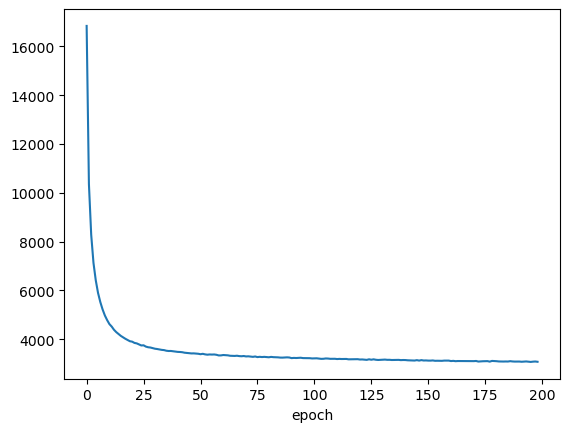

In [48]:
#check loss curve
loss=pd.read_table(f"{directory}/training_{model_output_name}.log",sep=',',header=None)
#plot loss curve
plt.plot(loss.iloc[:,-1].str.extract(r'Average Loss: (\d+\.\d+)').astype(float)[:])
plt.xlabel('epoch')

In [ ]:
# Save the trained model once training stabilizes
VAEmodel.eval()
torch.save(VAEmodel.state_dict(), f"./training_{model_output_name}.json")